
# Diabetes prediksjon


## 1) Importer biblioteker

In [20]:

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    average_precision_score,
    confusion_matrix,
    classification_report,
)

# Matplotlib: vis figurer i notebook
%matplotlib inline


## 2) Last inn data

In [21]:

csv_path = "diabetes.csv"
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"Fant ikke '{csv_path}'. Legg fila i samme mappe som notatboken eller oppgi full sti.")

df = pd.read_csv(csv_path)

print("=== Preview of the dataset ===")
display(df.head(10))
print("\nShape:", df.shape)
print("Columns:", list(df.columns))


=== Preview of the dataset ===


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1



Shape: (768, 9)
Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


## 3) Del opp i features (X) og target (y)

In [22]:

target_col = "Outcome" if "Outcome" in df.columns else df.columns[-1]
if target_col != "Outcome":
    print(f"[Info] 'Outcome' column not found. Using last column as target: {target_col}")

X = df.drop(columns=[target_col])
y = df[target_col]

X.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


## 4) Pre-prosessering - datavask

In [23]:

candidate_cols = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]
zero_as_missing = [c for c in candidate_cols if c in X.columns]

X_clean = X.copy()
for c in zero_as_missing:
    X_clean[c] = X_clean[c].replace(0, np.nan)

# Oversikt over manglende etter erstatning
X_clean.isna().sum()


Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
dtype: int64

## 5) Splitter data opp i treningssett og testsett

In [24]:

strat = y if y.nunique() <= 20 else None
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y, test_size=0.2, random_state=42, stratify=strat
)

X_train.shape, X_test.shape


((614, 8), (154, 8))

## 6) Ytterligere pre-prossering og datavask

In [25]:

all_num_features = X_train.columns.tolist()

# ColumnTransformer som imputerer alle feature-kolonner
imputer_all = ColumnTransformer(
    transformers=[("impute_all", SimpleImputer(strategy="median"), all_num_features)],
    remainder="drop"
)


## 7) Baseline: RandomForest (med imputering)
Når et datasett har “hull” (f.eks. NaN, tomme celler eller verdier som er ugyldige som 0 i blodtrykk), må vi bestemme oss for hvordan vi håndterer dem. Mange maskinlæringsalgoritmer krasjer hvis de får NaN.

In [26]:

rf_base = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("rf", RandomForestClassifier(n_estimators=100, random_state=42))
])
rf_base.fit(X_train, y_train)
y_pred_base = rf_base.predict(X_test)

print("=== Baseline RF (med imputering) ===")
print("Accuracy :", accuracy_score(y_test, y_pred_base))
print("Precision:", precision_score(y_test, y_pred_base, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred_base, zero_division=0))
print("F1 Score :", f1_score(y_test, y_pred_base, zero_division=0))


=== Baseline RF (med imputering) ===
Accuracy : 0.7662337662337663
Precision: 0.6956521739130435
Recall   : 0.5925925925925926
F1 Score : 0.64


## 8) GradientBoostingClassifier (med imputering)

In [27]:

gb = Pipeline([
    ("impute", SimpleImputer(strategy="median")),   # sikrer ingen NaN treffer GB
    ("gb", GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ))
])
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
y_proba_gb = gb.predict_proba(X_test)[:, 1]

print("=== GradientBoostingClassifier (med imputering) ===")
print("Accuracy :", accuracy_score(y_test, y_pred_gb))
print("Precision:", precision_score(y_test, y_pred_gb, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred_gb, zero_division=0))
print("F1 Score :", f1_score(y_test, y_pred_gb, zero_division=0))
print("ROC AUC  :", roc_auc_score(y_test, y_proba_gb))


=== GradientBoostingClassifier (med imputering) ===
Accuracy : 0.7662337662337663
Precision: 0.6875
Recall   : 0.6111111111111112
F1 Score : 0.6470588235294118
ROC AUC  : 0.83


## 9) Pipeline: ColumnTransformer (imputer alle) + RandomForest

In [28]:

preprocess = ColumnTransformer(
    transformers=[("impute_all", SimpleImputer(strategy="median"), all_num_features)],
    remainder="drop"
)

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight=None
)

pipe = Pipeline(steps=[("prep", preprocess), ("rf", rf)])
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc = roc_auc_score(y_test, y_proba)

print("=== Test Metrics (Pipeline RF) ===")
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1-score : {f1:.3f}")
print(f"ROC AUC  : {roc:.3f}")

print("\nClassification report:\n", classification_report(y_test, y_pred, digits=3))


=== Test Metrics (Pipeline RF) ===
Accuracy : 0.740
Precision: 0.659
Recall   : 0.537
F1-score : 0.592
ROC AUC  : 0.816

Classification report:
               precision    recall  f1-score   support

           0      0.773     0.850     0.810       100
           1      0.659     0.537     0.592        54

    accuracy                          0.740       154
   macro avg      0.716     0.694     0.701       154
weighted avg      0.733     0.740     0.733       154



## 10) Feature importances (Random Forest)

Glucose                     0.267931
BMI                         0.159848
DiabetesPedigreeFunction    0.124381
Age                         0.121357
Insulin                     0.090604
BloodPressure               0.084977
Pregnancies                 0.079366
SkinThickness               0.071537
dtype: float64

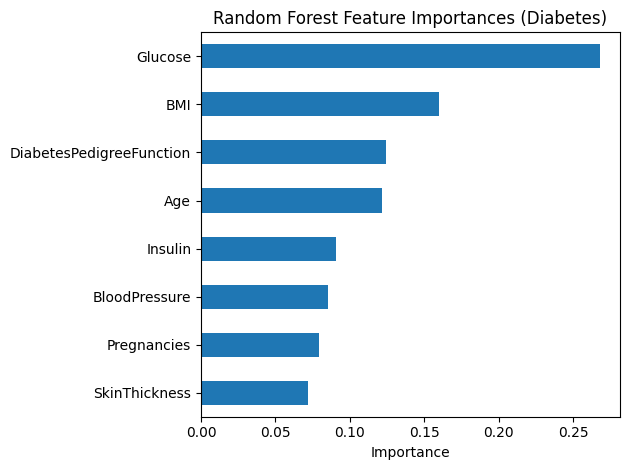

In [29]:

rf_model = pipe.named_steps["rf"]
transformed_feature_names = all_num_features

importances = pd.Series(rf_model.feature_importances_, index=transformed_feature_names).sort_values(ascending=False)
display(importances)

plt.figure()
importances.sort_values(ascending=True).plot(kind="barh")
plt.title("Random Forest Feature Importances (Diabetes)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


## 11) ROC- og PR-kurver (RF-pipeline)

<Figure size 640x480 with 0 Axes>

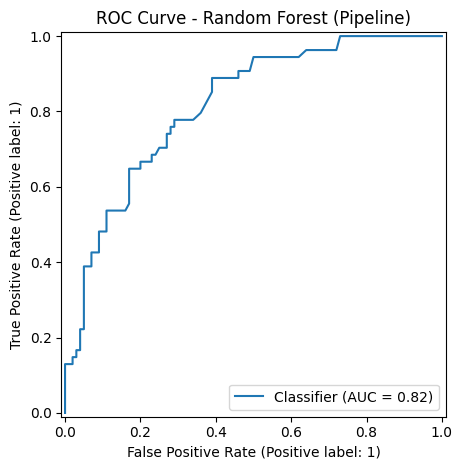

<Figure size 640x480 with 0 Axes>

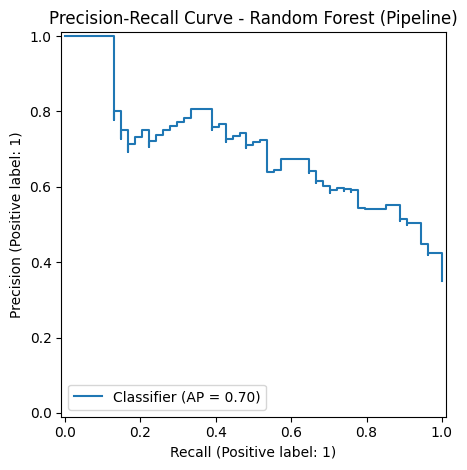

Average Precision (area under PR curve): 0.7016967934730705


In [30]:

plt.figure()
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve - Random Forest (Pipeline)")
plt.tight_layout()
plt.show()

plt.figure()
PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.title("Precision-Recall Curve - Random Forest (Pipeline)")
plt.tight_layout()
plt.show()

print("Average Precision (area under PR curve):", average_precision_score(y_test, y_proba))


## 12) Lagre renset kopi av datasettet

In [31]:

df_clean = X_clean.copy()
df_clean[target_col] = y
clean_path = "diabetes_clean.csv"
df_clean.to_csv(clean_path, index=False)
print(f"Saved cleaned dataset to: {clean_path}")


Saved cleaned dataset to: diabetes_clean.csv


## 13) Hyperparametertuning — Random Forest (n_estimators, max_features m.m.)

In [32]:
# 13) Hyperparametertuning — Random Forest (n_estimators, max_features m.m.)
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV  # nye imports for tuning
from scipy.stats import randint, uniform  # nye imports for fordelinger i RandomizedSearchCV

# Imputer ALLE features (robust mot NaN uansett tidligere rensing)
num_features_opt = X_train.columns.tolist()
preprocess_opt = ColumnTransformer(
    transformers=[("impute_all", SimpleImputer(strategy="median"), num_features_opt)],
    remainder="drop"
)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_pipe = Pipeline([("prep", preprocess_opt), ("rf", rf)])

rf_dist = {
    "rf__n_estimators": randint(200, 1201),                 # antall trær
    "rf__max_features": ["sqrt", "log2", 0.3, 0.5, 0.7],    # prediktorer per split
    "rf__max_depth": [None] + list(range(4, 25, 2)),
    "rf__min_samples_split": randint(2, 21),
    "rf__min_samples_leaf": randint(1, 11),
    "rf__bootstrap": [True, False],
    "rf__class_weight": [None, "balanced"],
}

rf_rs = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=rf_dist,
    n_iter=60,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)
rf_rs.fit(X_train, y_train)

rf_opt = rf_rs.best_estimator_
y_pred_rf_opt  = rf_opt.predict(X_test)
y_proba_rf_opt = rf_opt.predict_proba(X_test)[:, 1]

print("RF best CV F1:", rf_rs.best_score_)
print("RF best params:", rf_rs.best_params_)
print("\nRF (best) — test metrics")
print("Accuracy :", accuracy_score(y_test, y_pred_rf_opt))
print("Precision:", precision_score(y_test, y_pred_rf_opt, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred_rf_opt, zero_division=0))
print("F1       :", f1_score(y_test, y_pred_rf_opt, zero_division=0))
print("ROC AUC  :", roc_auc_score(y_test, y_proba_rf_opt))

rf_metrics = {
    "model": "RandomForest(best)",
    "n_estimators": rf_rs.best_params_["rf__n_estimators"],
    "max_features": rf_rs.best_params_["rf__max_features"],
    "accuracy": accuracy_score(y_test, y_pred_rf_opt),
    "precision": precision_score(y_test, y_pred_rf_opt, zero_division=0),
    "recall": recall_score(y_test, y_pred_rf_opt, zero_division=0),
    "f1": f1_score(y_test, y_pred_rf_opt, zero_division=0),
    "roc_auc": roc_auc_score(y_test, y_proba_rf_opt),
}


Fitting 10 folds for each of 60 candidates, totalling 600 fits
RF best CV F1: 0.6963005983672799
RF best params: {'rf__bootstrap': True, 'rf__class_weight': 'balanced', 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 10, 'rf__min_samples_split': 4, 'rf__n_estimators': 1071}

RF (best) — test metrics
Accuracy : 0.7467532467532467
Precision: 0.6086956521739131
Recall   : 0.7777777777777778
F1       : 0.6829268292682927
ROC AUC  : 0.8166666666666668


## 14) Hyperparametertuning — Gradient Boosting (n_estimators, learning_rate, max_features)

In [33]:
# 14) Hyperparametertuning — Gradient Boosting (n_estimators, learning_rate, max_features)
from sklearn.model_selection import RandomizedSearchCV  # kun ny hvis ikke importert i celle 13 (her er det samme obj)
from scipy.stats import randint, uniform                # samme som over

gb = GradientBoostingClassifier(random_state=42)
gb_pipe = Pipeline([("prep", preprocess_opt), ("gb", gb)])

gb_dist = {
    "gb__n_estimators": randint(200, 1001),          # antall trær
    "gb__learning_rate": uniform(0.01, 0.19),        # 0.01–0.20
    "gb__max_depth": randint(2, 6),                  # base-tre dybde
    "gb__min_samples_split": randint(2, 21),
    "gb__min_samples_leaf": randint(1, 11),
    "gb__subsample": uniform(0.6, 0.4),              # 0.6–1.0 (stochastic boosting)
    "gb__max_features": ["sqrt", "log2", None],
}

gb_rs = RandomizedSearchCV(
    estimator=gb_pipe,
    param_distributions=gb_dist,
    n_iter=60,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)
gb_rs.fit(X_train, y_train)

gb_opt = gb_rs.best_estimator_
y_pred_gb_opt  = gb_opt.predict(X_test)
y_proba_gb_opt = gb_opt.predict_proba(X_test)[:, 1]

print("GB best CV F1:", gb_rs.best_score_)
print("GB best params:", gb_rs.best_params_)
print("\nGB (best) — test metrics")
print("Accuracy :", accuracy_score(y_test, y_pred_gb_opt))
print("Precision:", precision_score(y_test, y_pred_gb_opt, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred_gb_opt, zero_division=0))
print("F1       :", f1_score(y_test, y_pred_gb_opt, zero_division=0))
print("ROC AUC  :", roc_auc_score(y_test, y_proba_gb_opt))

gb_metrics = {
    "model": "GradientBoosting(best)",
    "n_estimators": gb_rs.best_params_["gb__n_estimators"],
    "max_features": gb_rs.best_params_["gb__max_features"],
    "learning_rate": gb_rs.best_params_["gb__learning_rate"],
    "accuracy": accuracy_score(y_test, y_pred_gb_opt),
    "precision": precision_score(y_test, y_pred_gb_opt, zero_division=0),
    "recall": recall_score(y_test, y_pred_gb_opt, zero_division=0),
    "f1": f1_score(y_test, y_pred_gb_opt, zero_division=0),
    "roc_auc": roc_auc_score(y_test, y_proba_gb_opt),
}


Fitting 10 folds for each of 60 candidates, totalling 600 fits
GB best CV F1: 0.6373579085022298
GB best params: {'gb__learning_rate': np.float64(0.01906606426141327), 'gb__max_depth': 3, 'gb__max_features': None, 'gb__min_samples_leaf': 5, 'gb__min_samples_split': 15, 'gb__n_estimators': 419, 'gb__subsample': np.float64(0.618401056808701)}

GB (best) — test metrics
Accuracy : 0.7532467532467533
Precision: 0.6666666666666666
Recall   : 0.5925925925925926
F1       : 0.6274509803921569
ROC AUC  : 0.8255555555555555


## 15) Sammenligning og kurver + kladd til forklaring

,n_estimators,max_features,accuracy,precision,recall,f1,roc_auc,learning_rate
model,,,,,,,,
RandomForest(best),1071,sqrt,0.747,0.609,0.778,0.683,0.817,NaN
GradientBoosting(best),419,None,0.753,0.667,0.593,0.627,0.826,0.019



RF classification report:
               precision    recall  f1-score   support

           0      0.859     0.730     0.789       100
           1      0.609     0.778     0.683        54

    accuracy                          0.747       154
   macro avg      0.734     0.754     0.736       154
weighted avg      0.771     0.747     0.752       154


GB classification report:
               precision    recall  f1-score   support

           0      0.792     0.840     0.816       100
           1      0.667     0.593     0.627        54

    accuracy                          0.753       154
   macro avg      0.730     0.716     0.721       154
weighted avg      0.748     0.753     0.750       154



<Figure size 640x480 with 0 Axes>

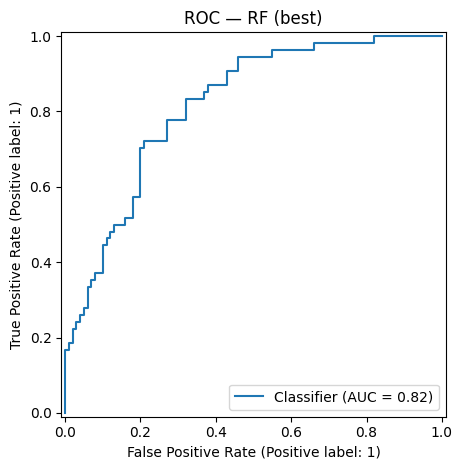

<Figure size 640x480 with 0 Axes>

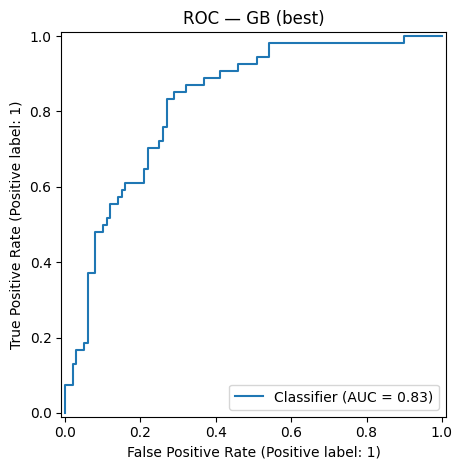

<Figure size 640x480 with 0 Axes>

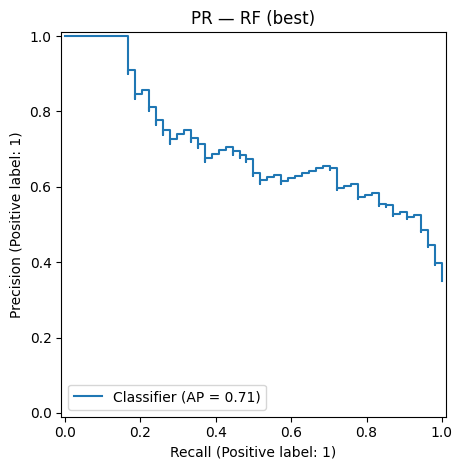

<Figure size 640x480 with 0 Axes>

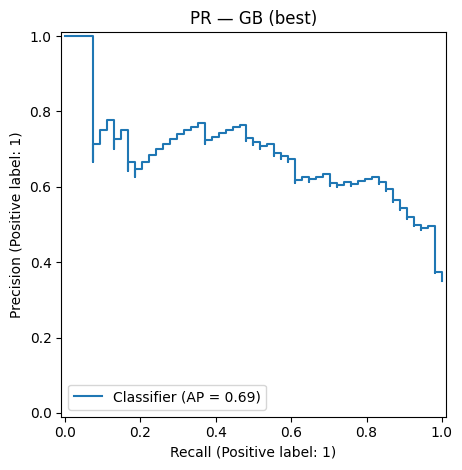

\nNotat — forklar forskjeller:
- Flere trær (n_estimators) reduserer varians; RF vs GB balanserer dette ulikt.
- max_features styrer tilfeldig variasjon per split: lavere verdi kan dempe overfitting (særlig i RF).
- GB: lavere learning_rate krever flere trær men kan gi bedre generalisering; høy rate kan overfitte.
- Kommentér trade-off precision/recall i lys av oppgavens kostnader (FP vs FN).


In [34]:
# 15) Sammenligning og kurver + kladd til forklaring
cmp = pd.DataFrame([rf_metrics, gb_metrics]).set_index("model")
display(cmp.round(3))

print("\nRF classification report:\n", classification_report(y_test, y_pred_rf_opt, digits=3))
print("\nGB classification report:\n", classification_report(y_test, y_pred_gb_opt, digits=3))

plt.figure(); RocCurveDisplay.from_predictions(y_test, y_proba_rf_opt); plt.title("ROC — RF (best)"); plt.tight_layout(); plt.show()
plt.figure(); RocCurveDisplay.from_predictions(y_test, y_proba_gb_opt); plt.title("ROC — GB (best)"); plt.tight_layout(); plt.show()

plt.figure(); PrecisionRecallDisplay.from_predictions(y_test, y_proba_rf_opt); plt.title("PR — RF (best)"); plt.tight_layout(); plt.show()
plt.figure(); PrecisionRecallDisplay.from_predictions(y_test, y_proba_gb_opt); plt.title("PR — GB (best)"); plt.tight_layout(); plt.show()

print("\\nNotat — forklar forskjeller:")
print("- Flere trær (n_estimators) reduserer varians; RF vs GB balanserer dette ulikt.")
print("- max_features styrer tilfeldig variasjon per split: lavere verdi kan dempe overfitting (særlig i RF).")
print("- GB: lavere learning_rate krever flere trær men kan gi bedre generalisering; høy rate kan overfitte.")
print("- Kommentér trade-off precision/recall i lys av oppgavens kostnader (FP vs FN).")
